# **Markov chains Mini-project**



In [1]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
np.random.seed(42)

## **MCMC simulation**

In [2]:

class FastBoard:
    def __init__(self, N, board=None):
        self.N = N
        self.energies = []
        
        if board is not None:
            self.board = board.copy()
        else:
            #self.board = np.random.randint(0, N, size=(N, N))
            self.board = np.zeros((N, N), dtype=int)
        self.offset = N
        self.counters = {
            'row_x': np.zeros((N, N), dtype=int),
            'row_y': np.zeros((N, N), dtype=int),
            'diag_xy_sum': np.zeros((N, 2*N), dtype=int),
            'diag_xy_diff': np.zeros((N, 2*N), dtype=int),
            'diag_xz_sum': np.zeros((N, 2*N), dtype=int),
            'diag_xz_diff': np.zeros((N, 2*N), dtype=int),
            'diag_yz_sum': np.zeros((N, 2*N), dtype=int),
            'diag_yz_diff': np.zeros((N, 2*N), dtype=int),
            'space_1': np.zeros((2*N, 2*N), dtype=int),
            'space_2': np.zeros((2*N, 2*N), dtype=int),
            'space_3': np.zeros((2*N, 2*N), dtype=int),
            'space_4': np.zeros((2*N, 2*N), dtype=int),
        }
        
        self.current_energy = 0
        self._compute_initial_energy()
        self.energies.append(self.current_energy)

    def convert(self):
        coords = []
        for x in range(self.N):
            for y in range(self.N):
                z = self.board[x,y]
                coords.append((int(x), int(y), int(z)))
        return coords


    def step(self, temperature, n=1):
        """
        Performs n Metropolis-Hastings steps.
        """
        if isinstance(temperature, (int, float)):
            temps = [temperature] * n
        else:
            temps = temperature

        for i in range(n):
            x = np.random.randint(self.N)
            y = np.random.randint(self.N)
            current_z = self.board[x, y]
            new_z = np.random.randint(self.N)

            if current_z == new_z:
                self.energies.append(self.current_energy)
                continue

            dE_remove = self._get_energy_change(x, y, current_z, -1) 
            dE = self._calculate_transition_delta(x, y, current_z, new_z)


            if dE < 0 or np.random.rand() < np.exp(-dE / temps[i]):
                self._update_counters(x, y, current_z, -1)
                self._update_counters(x, y, new_z, 1)
                self.board[x, y] = new_z
                self.current_energy += dE

            self.energies.append(self.current_energy)

    def _calculate_transition_delta(self, x, y, old_z, new_z):
        """
        Calculates dE without modifying state.
        dE = (Cost of new pos) - (Cost of old pos)
        """
        loss = self._sum_conflicts(x, y, old_z) - 12
        gain = self._sum_conflicts(x, y, new_z)
        return gain - loss

    def _sum_conflicts(self, x, y, z):
        """Returns total queens sharing lines with (x,y,z) from current counters."""
        off = self.offset
        total = 0
        total += self.counters['row_x'][y, z]
        total += self.counters['row_y'][x, z]
        total += self.counters['diag_xy_sum'][z, x + y]
        total += self.counters['diag_xy_diff'][z, x - y + off]
        total += self.counters['diag_xz_sum'][y, x + z]
        total += self.counters['diag_xz_diff'][y, x - z + off]
        total += self.counters['diag_yz_sum'][x, y + z]
        total += self.counters['diag_yz_diff'][x, y - z + off]
        total += self.counters['space_1'][x - y + off, y - z + off]
        total += self.counters['space_2'][x - y + off, y + z]
        total += self.counters['space_3'][x + y, y - z + off]
        total += self.counters['space_4'][x + y, y + z]
        return total

    def _update_counters(self, x, y, z, delta):
        """Updates internal counters when a queen is added (+1) or removed (-1)."""
        off = self.offset
        self.counters['row_x'][y, z] += delta
        self.counters['row_y'][x, z] += delta
        self.counters['diag_xy_sum'][z, x + y] += delta
        self.counters['diag_xy_diff'][z, x - y + off] += delta
        self.counters['diag_xz_sum'][y, x + z] += delta
        self.counters['diag_xz_diff'][y, x - z + off] += delta
        self.counters['diag_yz_sum'][x, y + z] += delta
        self.counters['diag_yz_diff'][x, y - z + off] += delta
        self.counters['space_1'][x - y + off, y - z + off] += delta
        self.counters['space_2'][x - y + off, y + z] += delta
        self.counters['space_3'][x + y, y - z + off] += delta
        self.counters['space_4'][x + y, y + z] += delta

    def _compute_initial_energy(self):
        """One-time expensive setup (O(N^2))."""
        self.current_energy = 0
        for key in self.counters:
            self.counters[key].fill(0)

        for x in range(self.N):
            for y in range(self.N):
                z = self.board[x, y]
                self.current_energy += self._sum_conflicts(x, y, z)
                self._update_counters(x, y, z, 1)
    
    def _get_energy_change(self, x, y, z, delta):
        """Helper to compute energy delta if we add/remove queen at x,y,z."""
        count = self._sum_conflicts(x, y, z)
        if delta == -1: return -(count - 12)
        if delta == 1: return count
        return 0

    def get_3d_board(self):
        """Returns the full NxNxN boolean board for visualization."""
        b = np.zeros((self.N, self.N, self.N), dtype=int)
        for x in range(self.N):
            for y in range(self.N):
                b[x, y, self.board[x, y]] = 1
        return b

## **Further tasks and questions**

### Question 1 

100%|██████████| 20/20 [00:19<00:00,  1.00it/s]


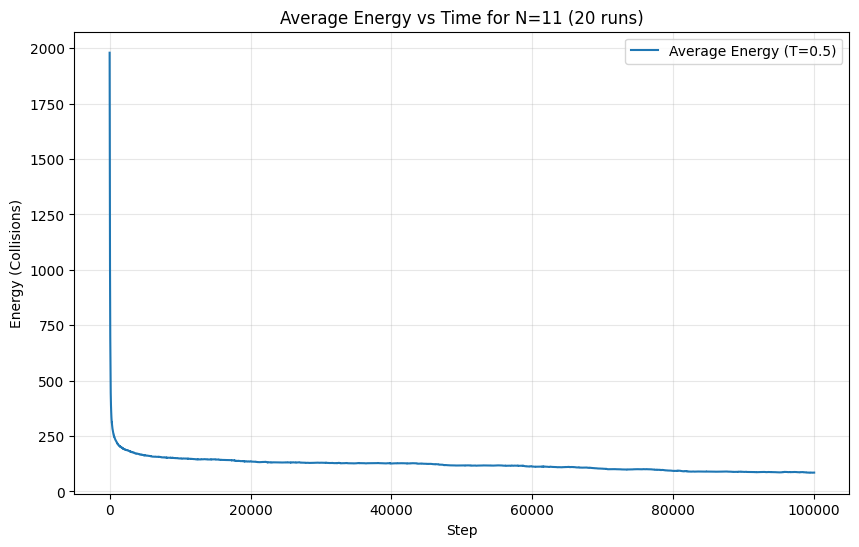

array([1980.  , 1954.15, 1928.2 , ...,   84.85,   84.85,   84.85],
      shape=(100001,))

In [3]:
def average_energy_fixed_T(N, steps, runs=5, temperature=0.5):
    """
    Task 1: For a fixed N, represent the energy as a function of time.
    The energy is averaged across multiple runs (no simulated annealing).
    """

    all_energies = []

    for r in tqdm(range(runs)):
        board = FastBoard(N)
        board.step(temperature, n=steps)
        all_energies.append(board.energies)

    avg_energy = np.mean(np.array(all_energies), axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(avg_energy, label=f"Average Energy (T={temperature})")
    plt.xlabel("Step")
    plt.ylabel("Energy (Collisions)")
    plt.title(f"Average Energy vs Time for N={N} ({runs} runs)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    return avg_energy


average_energy_fixed_T(N=11, steps=100000, runs=20, temperature=0.5)

### Question 2

In [4]:
def run_ensemble(N, steps, temp_schedule, runs=5):
    """
    Runs the simulation 'runs' times and returns the average energy history.
    """
    all_energies = []
    
    for r in tqdm(range(runs)):
        board = FastBoard(N)
        board.step(temp_schedule, n=steps)
        all_energies.append(board.energies)
        
    # Average across runs (axis 0)
    avg_energies = np.mean(np.array(all_energies), axis=0)
    return avg_energies

def average_run(N, steps, runs, t_annealing=None, t_constant=0.5):
    """
    Tasks 1 & 2: Plot Energy vs Time and Compare Annealing vs Constant Temp.
    """
    
    if t_annealing is None:
        t_annealing = np.linspace(3, 0.1, steps)
    else:
        t_annealing = np.linspace(t_annealing[0], t_annealing[1], steps)

    # Run simulations
    print(f"  Simulating Annealing (N={N})...")
    e_anneal = run_ensemble(N, steps, t_annealing, runs=runs)
    
    print(f"  Simulating Constant Temp (N={N})...")
    e_const = run_ensemble(N, steps, t_constant, runs=runs)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(e_anneal, label='Simulated Annealing', color='red')
    plt.plot(e_const, label=f'Constant Temp (T={t_constant})', color='blue', alpha=0.6)
    
    plt.title(f"Average Energy Optimization (N={N}, {runs} runs)")
    plt.xlabel("Step")
    plt.ylabel("Energy (Collisions)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def compare_N(n_values, steps, repeats=10, t_schedule=None, title="linear"):
    """
    Tasks 3 & 4: Minimal Energy vs N.
    """

    min_energies = []
    if t_schedule is None:
        t_schedule = np.linspace(5, 0.5, steps)
    
    for N in tqdm(n_values, desc="Testing N sizes"):
        best_e_for_N = float('inf')
        for _ in range(repeats):
            board = FastBoard(N)
            board.step(t_schedule, n=steps)
            if min(board.energies) < best_e_for_N:
                best_e_for_N = min(board.energies)
            if best_e_for_N == 0:
                solution = board.convert()
                print(f"Solution des N^2 reines pour N = {N} : {solution}")
                break
        print(f"  N={N}, Best Energy Found: {best_e_for_N}")
        min_energies.append(best_e_for_N)
    plt.figure(figsize=(10, 6))
    plt.plot(n_values, min_energies, marker='o', linestyle='-', color='purple')
    
    zeros = [n for n, e in zip(n_values, min_energies) if e == 0]
    if zeros:
        print(f"Perfect solutions found for N = {zeros}")
        
    plt.title(f"Minimal Energy Reached vs. Board Size N with {title} annealing")
    plt.xlabel("N (Board Size NxNxN)")
    plt.ylabel("Minimal Energy Found")
    plt.xticks(n_values)
    plt.grid(True, alpha=0.3)
    
    plt.show()

In [5]:
def make_linear_schedule(T0, T1, steps):
    return np.linspace(T0, T1, steps)

def make_polynomial_schedule(T0, T1, steps, power=2):
    x = np.linspace(0, 1, steps)
    return T0 + (T1 - T0) * (x ** power)

def make_exponential_schedule(T0, T1, steps):
    return T0 * (T1 / T0) ** (np.linspace(0, 1, steps))

def make_batch_schedule(T0, T1, steps, batches=5):
    temps = []
    batch_size = steps // batches
    delta = (T0 - T1) / batches
    for i in range(batches):
        Ti = T0 - i * delta
        temps += [Ti] * batch_size
    # Complete remaining steps in case of integer mismatch
    while len(temps) < steps:
        temps.append(T1)
    return np.array(temps)


Simulating → Constant (T=0.7)


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [01:38<00:00,  1.97s/it]


Simulating → Linear


100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


Simulating → Polynomial (power=2)


100%|██████████| 50/50 [01:35<00:00,  1.91s/it]


Simulating → Exponential


100%|██████████| 50/50 [01:31<00:00,  1.84s/it]


Simulating → piecewise constant(as seen in course)


100%|██████████| 50/50 [01:30<00:00,  1.80s/it]


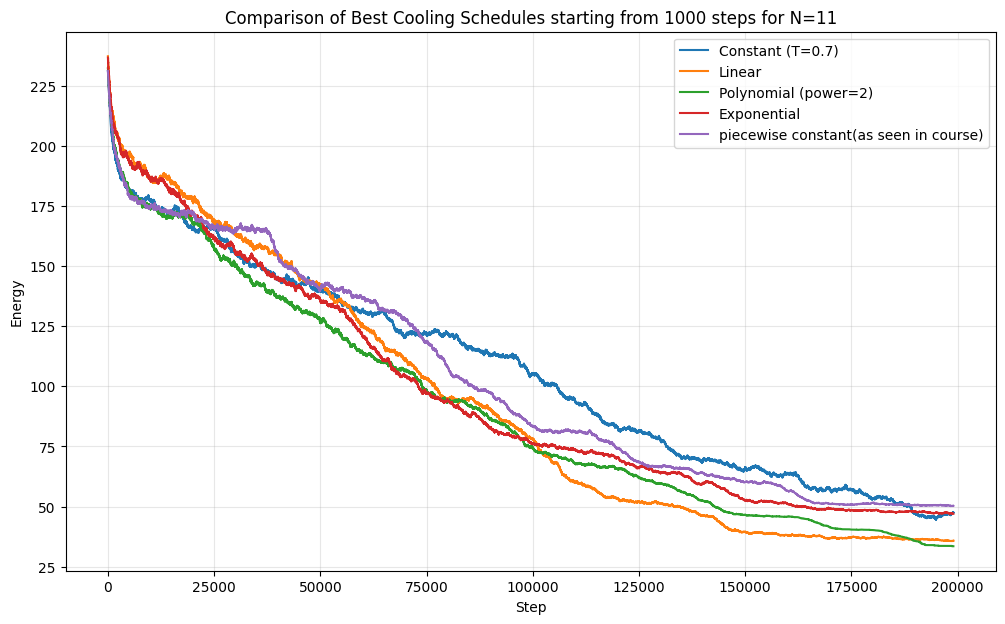

Simulating → Constant (T=0.7)
Simulating → Linear
Simulating → Polynomial (power=2)
Simulating → Exponential
Simulating → piecewise constant(as seen in course)


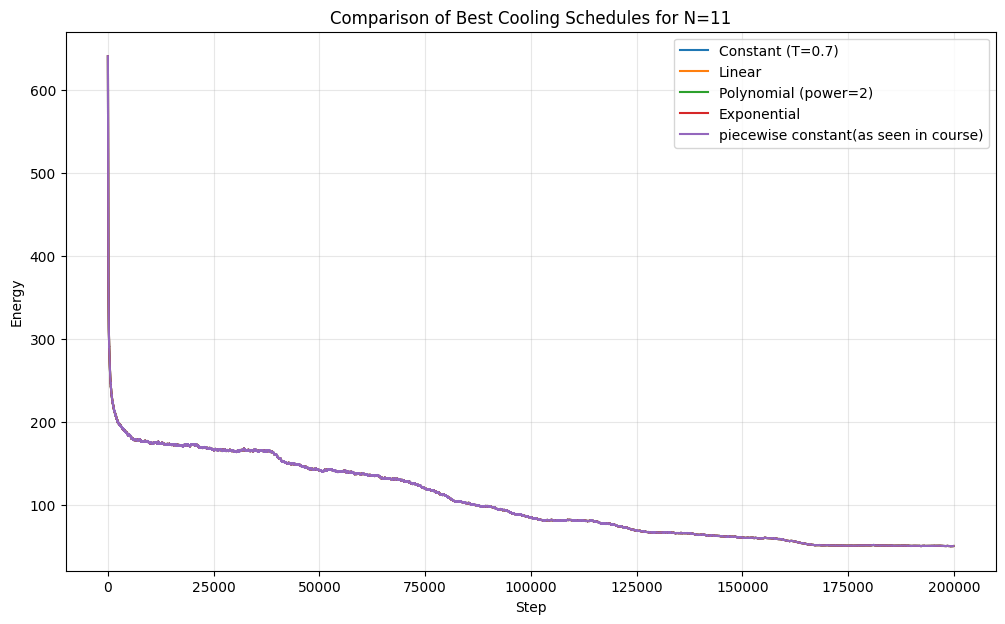

In [6]:


def plot_multiple_schedules(N, steps, runs=10):
    """
    Compare:
      - Constant temperature
      - Linear annealing
      - Polynomial annealing
      - Exponential annealing
      - Batch (piecewise constant)
    """ 





    schedules = {  #Bests parameters found with tuning
        "Constant (T=0.7)": 0.7,  
        "Linear": make_linear_schedule(0.8, 0.4, steps),
        "Polynomial (power=2)": make_polynomial_schedule(0.7, 0.1, steps, power=2),
        "Exponential": make_exponential_schedule(0.8, 0.4, steps),
        "piecewise constant(as seen in course)": make_batch_schedule(0.7, 0.3, steps, batches=5),
    }

    plt.figure(figsize=(12, 7))

    for name, schedule in schedules.items():
        print(f"Simulating → {name}")
        energies = run_ensemble(N, steps, schedule, runs=runs)
        plt.plot(energies[1000:], label=name)

    plt.title(f"Comparison of Best Cooling Schedules starting from 1000 steps for N={N}")
    plt.xlabel("Step")
    plt.ylabel("Energy")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    plt.figure(figsize=(12, 7))

    for name, schedule in schedules.items():
        print(f"Simulating → {name}")
        plt.plot(energies[100:], label=name)

    plt.title(f"Comparison of Best Cooling Schedules for N={N}")
    plt.xlabel("Step")
    plt.ylabel("Energy")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


np.random.seed(21)
plot_multiple_schedules(N=11, steps=200000, runs=50)



### Question 3

In [14]:
def compare_N_all_methods(n_values, steps, repeats=10, title="All annealing methods"):
    """
    Tasks 3 & 4: Minimum energy vs. N for ALL annealing methods.
    For each N, test all methods and keep the best result.
    """
    
    # Data preparation
    results = {}
    methods = ['constant', 'linear', 'polynomial', 'exponential', 'batch']
    
    for N in tqdm(n_values, desc="Testing N sizes"):
        best_e_for_N = float('inf')
        best_method_for_N = None

        for method in methods:
            if method == 'constant':
                t_schedule = 0.7
            elif method == 'linear':
                t_schedule = make_linear_schedule(0.8, 0.4, steps)
            elif method == 'polynomial':
                t_schedule = make_polynomial_schedule(0.7, 0.1, steps, power=2)
            elif method == 'exponential':
                t_schedule = make_exponential_schedule(0.8, 0.4, steps)
            elif method == 'batch':
                t_schedule = make_batch_schedule(0.7, 0.3, steps, batches=5)
            
            for _ in range(repeats):
                board = FastBoard(N)
                board.step(t_schedule, n=steps)
                current_min = min(board.energies)
                
                if current_min < best_e_for_N:
                    best_e_for_N = current_min
                    best_method_for_N = method
                
                # If perfect solution, stop
                if best_e_for_N == 0:
                    solution = board.convert()
                    print(f"Perfect solution found for N = {N} with method {method}")
                    break
            
            if best_e_for_N == 0:
                break
        
        results[N] = {
            'best_energy': best_e_for_N,
            'best_method': best_method_for_N
        }
        print(f"  N={N}, Best Energy Found: {best_e_for_N} (method: {best_method_for_N})")
    
    n_values_sorted = sorted(results.keys())
    min_energies = [results[N]['best_energy'] for N in n_values_sorted]
    best_methods = [results[N]['best_method'] for N in n_values_sorted]
    
    print("\n" + "="*50)
    print("RESULTS SUMMARY")
    print("="*50)
    for i, N in enumerate(n_values_sorted):
        print(f"N={N}: Minimum energy = {min_energies[i]} (method: {best_methods[i]})")
    
    zeros = [N for N, e in zip(n_values_sorted, min_energies) if e == 0]
    if zeros:
        print(f"\nPerfect solutions found for N = {zeros}")
    
    plt.figure(figsize=(12, 7))
    
    method_colors = {
        'constant': 'blue',
        'linear': 'red',
        'polynomial': 'green',
        'exponential': 'orange',
        'batch': 'purple'
    }
    
    for i, (N, energy, method) in enumerate(zip(n_values_sorted, min_energies, best_methods)):
        plt.scatter(N, energy, color=method_colors[method], s=100, alpha=0.7, 
                   edgecolors='black', linewidth=1)
    
    plt.plot(n_values_sorted, min_energies, linestyle='-', color='gray', alpha=0.5)
    
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=method_colors[method], 
                             markersize=10, label=method)
                      for method in method_colors]
    plt.legend(handles=legend_elements, title="Methods", loc='upper left')
    
    plt.title(f"Minimum Energy Achieved vs. Board Size N\n(best method among all)")
    plt.xlabel("N (Board Size NxNxN)")
    plt.ylabel("Minimum Energy Found")
    plt.xticks(n_values_sorted)
    plt.grid(True, alpha=0.3)
    
    for N, energy in zip(n_values_sorted, min_energies):
        if energy == 0:
            plt.annotate('✓', xy=(N, energy), xytext=(0, 10),
                        textcoords='offset points', ha='center',
                        fontsize=12, color='green', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return results

Testing N sizes:   6%|▌         | 1/17 [01:43<27:31, 103.22s/it]

  N=3, Best Energy Found: 13 (method: constant)


Testing N sizes:  12%|█▏        | 2/17 [03:28<26:02, 104.19s/it]

  N=4, Best Energy Found: 23 (method: constant)


Testing N sizes:  18%|█▊        | 3/17 [05:16<24:45, 106.07s/it]

  N=5, Best Energy Found: 34 (method: constant)


Testing N sizes:  24%|██▎       | 4/17 [07:06<23:19, 107.63s/it]

  N=6, Best Energy Found: 47 (method: linear)


Testing N sizes:  29%|██▉       | 5/17 [08:55<21:35, 107.99s/it]

  N=7, Best Energy Found: 55 (method: linear)


Testing N sizes:  35%|███▌      | 6/17 [10:44<19:53, 108.48s/it]

  N=8, Best Energy Found: 56 (method: linear)


Testing N sizes:  41%|████      | 7/17 [12:34<18:11, 109.12s/it]

  N=9, Best Energy Found: 57 (method: constant)


Testing N sizes:  47%|████▋     | 8/17 [14:23<16:19, 108.82s/it]

  N=10, Best Energy Found: 39 (method: constant)


Testing N sizes:  53%|█████▎    | 9/17 [14:27<10:10, 76.29s/it] 

Perfect solution found for N = 11 with method constant
  N=11, Best Energy Found: 0 (method: constant)


Testing N sizes:  59%|█████▉    | 10/17 [16:19<10:10, 87.28s/it]

  N=12, Best Energy Found: 25 (method: exponential)


Testing N sizes:  65%|██████▍   | 11/17 [17:58<09:04, 90.82s/it]

Perfect solution found for N = 13 with method batch
  N=13, Best Energy Found: 0 (method: batch)


Testing N sizes:  71%|███████   | 12/17 [19:49<08:04, 96.93s/it]

  N=14, Best Energy Found: 164 (method: linear)


Testing N sizes:  76%|███████▋  | 13/17 [21:43<06:48, 102.24s/it]

  N=15, Best Energy Found: 127 (method: batch)


Testing N sizes:  82%|████████▏ | 14/17 [23:38<05:18, 106.04s/it]

  N=16, Best Energy Found: 223 (method: polynomial)


Testing N sizes:  88%|████████▊ | 15/17 [25:35<03:38, 109.26s/it]

  N=17, Best Energy Found: 252 (method: polynomial)


Testing N sizes:  94%|█████████▍| 16/17 [27:31<01:51, 111.38s/it]

  N=18, Best Energy Found: 284 (method: polynomial)


Testing N sizes: 100%|██████████| 17/17 [29:27<00:00, 103.96s/it]

  N=19, Best Energy Found: 315 (method: polynomial)

RESULTS SUMMARY
N=3: Minimum energy = 13 (method: constant)
N=4: Minimum energy = 23 (method: constant)
N=5: Minimum energy = 34 (method: constant)
N=6: Minimum energy = 47 (method: linear)
N=7: Minimum energy = 55 (method: linear)
N=8: Minimum energy = 56 (method: linear)
N=9: Minimum energy = 57 (method: constant)
N=10: Minimum energy = 39 (method: constant)
N=11: Minimum energy = 0 (method: constant)
N=12: Minimum energy = 25 (method: exponential)
N=13: Minimum energy = 0 (method: batch)
N=14: Minimum energy = 164 (method: linear)
N=15: Minimum energy = 127 (method: batch)
N=16: Minimum energy = 223 (method: polynomial)
N=17: Minimum energy = 252 (method: polynomial)
N=18: Minimum energy = 284 (method: polynomial)
N=19: Minimum energy = 315 (method: polynomial)

Perfect solutions found for N = [11, 13]


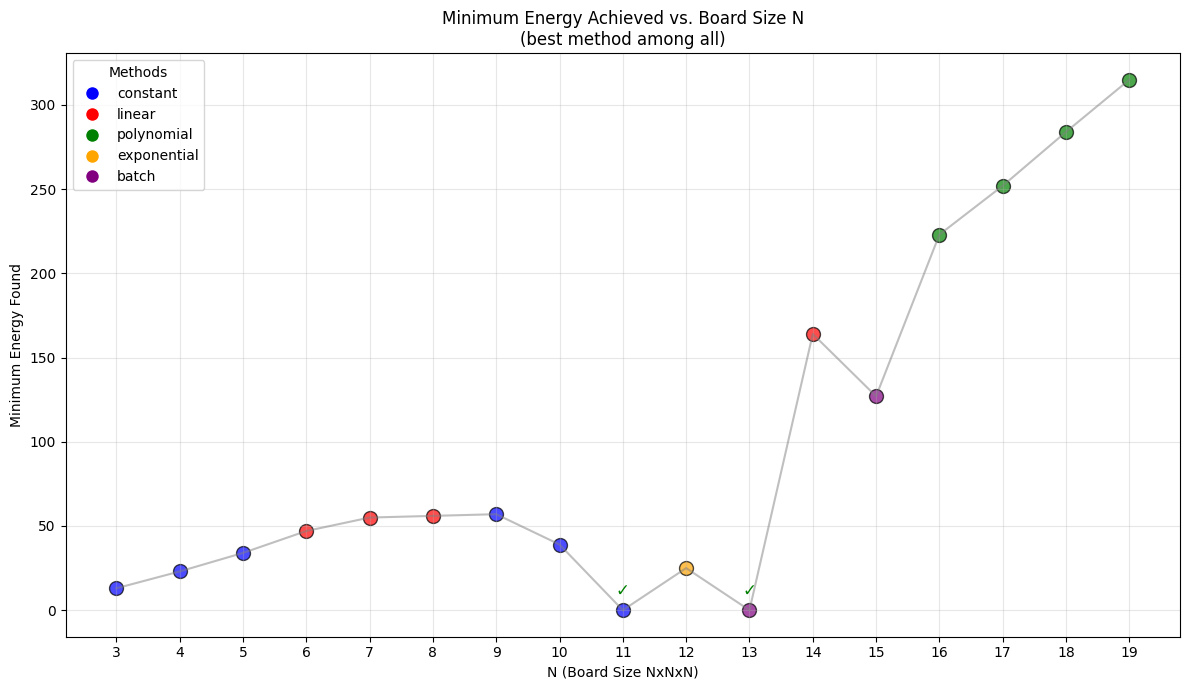

In [15]:
n_values = range(3,20)
steps = 500000
repeats = 5
np.random.seed(33)
results = compare_N_all_methods(n_values, steps, repeats, title="Comparaison de toutes les méthodes")

### Question 4

> It seems that for N=11 and N=13, the minimal energy is significantly lower than the others(it reached global minimum, with cost function equal to 0), as we found a solution. For N=12 it seems also lower, but we did not manage to find a solution